# Where is Waldo?

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from matplotlib.ticker import MaxNLocator
import numpy as np
from PIL import Image
import os
import random
import csv

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split, Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import WeightedRandomSampler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from tqdm import tqdm

/home/rosa/.local/lib/python3.10/site-packages/anaconda3/envs/dl-waldo/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/rosa/.local/lib/python3.10/site-packages/anaconda3/envs/dl-waldo/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # use GPU if available
print(f"Using {device}")

Using cuda


## Data Loading

In [4]:
# Custom Dataset for loading patches
class WaldoPatchDataset(Dataset):
    def __init__(self, directories, reshape_size):
        self.filenames = []
        self.labels = []
        self.reshape_size = reshape_size
        self.to_tensor = transforms.ToTensor()

        # Loop through the directories
        for directory, label in directories:
            for fname in os.listdir(directory):
                if fname.lower().endswith('.jpg'):
                    full_path = os.path.join(directory, fname)
                    self.filenames.append(full_path)
                    self.labels.append(label)

        self.pos_labels = np.nonzero(self.labels)[0]


    # Get length
    def __len__(self):
        return len(self.filenames)
        

    def __getitem__(self, idx):
        # Load an image
        img = Image.open(self.filenames[idx])

        # Resize image
        img = img.resize(self.reshape_size)
        img = self.to_tensor(img)

        # Get the label
        label = self.labels[idx]

        return img, label

In [5]:
# Directories which contain
waldo_directories = [
    # Reshape all images to 128x128
    ("./data/64/waldo", 1),
    ("./data/64/notwaldo", 0),
    ("./data/128/waldo", 1),
    ("./data/128/notwaldo", 0)
]

# Create the dataset
waldo_dataset = WaldoPatchDataset(waldo_directories, (128, 128))

# Calculate split sizes
total_size = len(waldo_dataset)
test_size = int(0.1 * total_size)
train_eval_size = total_size - test_size
train_size = int(0.9 * train_eval_size)
val_size = train_eval_size - train_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(waldo_dataset, [train_size, val_size, test_size])

# Count labels in each subset
def count_labels_in_subset(dataset, subset):
    label_0_count = 0
    label_1_count = 0

    for idx in subset.indices:
        label = dataset.labels[idx]
        if label == 0:
            label_0_count += 1
        elif label == 1:
            label_1_count += 1

    return label_0_count, label_1_count

label_0_train_size, label_1_train_size = count_labels_in_subset(waldo_dataset, train_dataset)
label_0_val_size, label_1_val_size = count_labels_in_subset(waldo_dataset, val_dataset)
label_0_test_size, label_1_test_size = count_labels_in_subset(waldo_dataset, test_dataset)

# Print dataset statistics
print(f"Length of whole dataset: {len(waldo_dataset)}")
print("----------------------------------------------------------")
print(f"Length of the training set: {len(train_dataset)}")
print(f"Number of label 0 in the training set: {label_0_train_size}")
print(f"Number of label 1 in the training set: {label_1_train_size}")
print("----------------------------------------------------------")
print(f"Length of the validation set: {len(val_dataset)}")
print(f"Number of label 0 in the validation set: {label_0_val_size}")
print(f"Number of label 1 in the validation set: {label_1_val_size}")
print("----------------------------------------------------------")
print(f"Length of the test set: {len(test_dataset)}")
print(f"Number of label 0 in the test set: {label_0_test_size}")
print(f"Number of label 1 in the test set: {label_1_test_size}")

Length of whole dataset: 6720
----------------------------------------------------------
Length of the training set: 5443
Number of label 0 in the training set: 5390
Number of label 1 in the training set: 53
----------------------------------------------------------
Length of the validation set: 605
Number of label 0 in the validation set: 599
Number of label 1 in the validation set: 6
----------------------------------------------------------
Length of the test set: 672
Number of label 0 in the test set: 665
Number of label 1 in the test set: 7


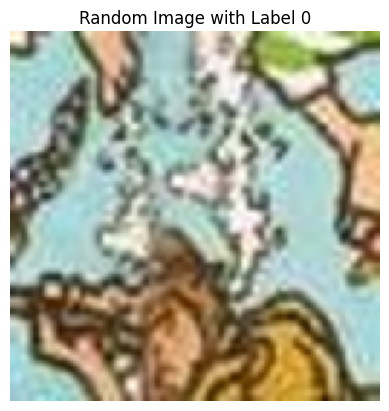

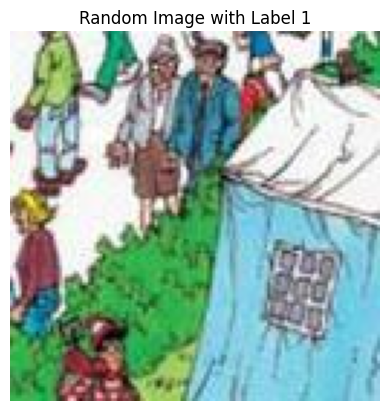

In [6]:
def show_random_image_from_each_label(dataset):
    # Get unique labels in the dataset (0 & 1)
    unique_labels = set(dataset.labels)
    # Iterate for each unique label
    for label in unique_labels:
        # Find indices for current label
        indices_for_label = [i for i, l in enumerate(dataset.labels) if l == label]

        # Choose a random index for the current label
        random_index = random.choice(indices_for_label)
        # Get the image and label
        image, _ = dataset[random_index]

        # Display the random chosen image with the label
        plt.figure()
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f"Random Image with Label {label}")
        plt.axis('off')
        plt.show()

show_random_image_from_each_label(waldo_dataset)

## Data Processing

In [32]:
def compute_mean_std(dataset):
    sum_rgb = torch.zeros(3)
    sum_rgb_squared = torch.zeros(3)
    num_pixels = 0
    to_tensor = transforms.ToTensor()

    for img, _ in dataset:
        img = img.view(3, -1)  # Flatten the image to get the pixel values for each channel
        sum_rgb += img.sum(dim=1)  # Sum up all the pixel values for each RGB channel
        sum_rgb_squared += (img ** 2).sum(dim=1)  # Sum up the squares of all pixel values for each RGB channel
        num_pixels += img.shape[1]  # Count the total number of pixels processed

    mean = sum_rgb / num_pixels  # Compute the mean for each RGB channel
    std = (sum_rgb_squared / num_pixels - mean ** 2).sqrt()  # Compute the standard deviation for each RGB channel

    return mean, std

mean_train, std_train = compute_mean_std(train_dataset)
print("Mean of RGB channels:", mean_train)
print("Standard Deviation of RGB channels:", *std_train)

Mean of RGB channels: tensor([0.6360, 0.5852, 0.4928])
Standard Deviation of RGB channels: tensor(0.2760) tensor(0.2842) tensor(0.2846)


## Step 1: Triplet Loss

In [72]:
# Augmented/transformed dataset
class AugmentedDataset(Dataset):
    def __init__(self, dataset, transform=None, aug_indices=[], aug_transforms=[]):
        self.dataset = dataset
        self.transform = transform
        self.aug_indices = aug_indices
        self.aug_transforms = aug_transforms


    # Increase selected indices in dataset based on amount of augmentation transforms
    def __len__(self):
        return len(self.dataset) + (len(self.aug_transforms) * len(self.aug_indices))

    # Get a sample from the augmented/transformed dataset
    def __getitem__(self, idx):
        # If augmentation is applied, adjust the index to get the correct augmented sample
        if self.aug_indices and idx >= len(self.dataset):
            idx -= len(self.dataset)
            img_idx = self.aug_indices[idx % len(self.aug_indices)]
            transform_idx = idx // len(self.aug_indices)
            augment = True
        else:
            img_idx = idx
            augment = False
        
        # Get the original image and label
        img, label = self.dataset[img_idx]

        # Apply any specified transformation to the original image
        if self.transform:
            img = self.transform(img)

        # Apply augmentation if needed
        if augment:
            img = self.aug_transforms[transform_idx](img)

        return img, label

In [73]:
class TripletWaldoDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.labels = [label for _, label in subset]

        # Precompute positive class label indices for efficiency
        self.label_to_indices = {label: np.where(np.array(self.labels) == label)[0]
                                 for label in np.unique(self.labels)}

        # Precompute negative class label indices
        self.label_to_negative_indices = {label: np.where(np.array(self.labels) != label)[0]
                                          for label in np.unique(self.labels)}


    def __len__(self):
        return len(self.subset)


    def __getitem__(self, idx):
        # Get anchor and its label
        anchor_img, anchor_label = self.subset[idx]

        # Apply transform to anchor if provided
        if self.transform:
            anchor_img = self.transform(anchor_img)

        # Choose a positive example
        positive_idx = idx
        while positive_idx == idx:
            positive_idx = np.random.choice(self.label_to_indices[anchor_label])

        # Choose a negative example
        negative_label = np.random.choice(list(self.label_to_negative_indices.keys()))
        negative_idx = np.random.choice(self.label_to_negative_indices[negative_label])

        # Load image
        positive_img, _ = self.subset[positive_idx]
        negative_img, _ = self.subset[negative_idx]

        # Apply transform if provided
        if self.transform:
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img, anchor_label

In [75]:
# Define normalization transform using train mean and std
transform_normalizer = transforms.Normalize(mean_train, std_train) # Apply normalization using the computed mean and std

# Define transformation pipeline for the triplet training dataset 
triplet_train_transform = transforms.Compose([
    transform_normalizer,
    transforms.RandomHorizontalFlip(p=0.2)
])

# Define a list of augmentation transforms
augment_transforms = [
    transforms.GaussianBlur(3),
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2)
]

# Get indices of positive samples in traning set to augment
train_pos_labels = [
    idx
    for idx, (_, label) in enumerate(train_dataset)
    if label == 1
]

# Create augmented and transformed datasets
aug_train_dataset = AugmentedDataset(train_dataset, transform=transform_normalizer, aug_indices=train_pos_labels, aug_transforms=augment_transforms)
aug_val_dataset = AugmentedDataset(val_dataset, transform=transform_normalizer)
aug_test_dataset = AugmentedDataset(test_dataset, transform=transform_normalizer)

# Create triplet datasets
triplet_train_dataset = TripletWaldoDataset(aug_train_dataset)
triplet_val_dataset = TripletWaldoDataset(aug_val_dataset)
triplet_test_dataset = TripletWaldoDataset(aug_test_dataset)

# Create triplet data loaders
triplet_train_loader = DataLoader(triplet_train_dataset, batch_size=16,   shuffle=True)
triplet_val_loader = DataLoader(triplet_val_dataset, batch_size=16,  shuffle=False)
triplet_test_loader = DataLoader(triplet_test_dataset, batch_size=16,  shuffle=False)

In [76]:
# Taken from the lab session
# Mainly unchanged, except for the hyperparameters

class Patchify(nn.Module):
    def __init__(self, img_size=128, patch_size=16, embed_dim=768):
        super().__init__()
        self.num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.proj = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, E, P, P)
        x = x.flatten(2).transpose(1, 2)  # (B, N, E)
        return x


# Other classes (FeedForward, MultiHeadAttention, Transformer) remain unchanged
class FeedForward(nn.Module):
    def __init__(self, dim, dropout=0.):
        super().__init__()

        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.):
        super().__init__()
        self.dim = dim
        self.heads = heads

        self.query = nn.Linear(dim, dim)
        self.keys = nn.Linear(dim, dim)
        self.values = nn.Linear(dim, dim)

        self.norm = nn.LayerNorm(dim)

        self.out_proj = nn.Linear(dim, dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # N is the total number of patches
        B, N, C = x.shape

        x = self.norm(x)         # (B, N, C)

        query = self.query(x)    # (B, N, C)
        key = self.keys(x)       # (B, N, C)
        value = self.values(x)   # (B, N, C)

        dim_head = C // self.heads

        # Split (B,N,C) into (B, N, num_heads, dim_head) and permute heads which yields a shape of (B, num_heads, N, dim_head)
        # each of the heads, should have (N, dim_head)
        query = query.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)
        key = key.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)
        value = value.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)

        # (B, num_heads, N, dim_head) with (B, num_heads, N, dim_head) --> (B, num_heads, N, N)
        attention_scores = torch.matmul(query, key.transpose(-1, -2))

        scale = dim_head ** -0.5   # (1 / sqrt(dim_head))
        attention_scores = attention_scores * scale
        attention_scores = F.softmax(attention_scores, dim = -1) # (B, num_heads, N, N)
        attention_scores = self.dropout(attention_scores)

        # extract the values
        # (B, num_heads, N, N) matmul (B, num_heads, N, dim_head) --> (B, num_heads, N, dim_head)
        out = torch.matmul(attention_scores, value)

        # (B, num_heads, N, dim_head) --> (B, N, num_heads, dim_head) --> (B, N, C)
        out = out.permute(0,2,1,3).flatten(2)   # or we can use .reshape(B, N, -1) rather than .flatten(2)
        out = self.out_proj(out)
        return out


class Transformer(nn.Module):
    def __init__(self, dim, num_layers, heads, dropout=0.):
        super().__init__()

        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])

        for _ in range(num_layers):
            self.layers.append(nn.ModuleList([
                MultiHeadAttention(dim, heads = heads, dropout = dropout),
                FeedForward(dim, dropout = dropout)]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

class ViT(nn.Module):
    # def __init__(self, image_size=128, patch_size=16, num_classes=2, dim=768, num_layers=6, heads=12, dropout=0.1):
    def __init__(self, image_size=128, patch_size=16, num_classes=2, dim=256, num_layers=3, heads=8, dropout=0.1):
        super().__init__()
        self.patchify = Patchify(image_size, patch_size, dim)
        self.pos_encoding = nn.Parameter(torch.randn(1, self.patchify.num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, num_layers, heads, dropout)
        self.classifier = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        B = x.shape[0]
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = self.patchify(x)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_encoding
        x = self.transformer(x)
        x = x[:, 0]  # Take the CLS token
        x = self.classifier(x)
        return x

In [77]:
# Define the triplet loss
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1).sqrt()  # Euclidean distance
        distance_negative = (anchor - negative).pow(2).sum(1).sqrt()
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [78]:
def train_triplet_epoch(model, train_loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    positive_distances = []
    negative_distances = []

    # Iterate over all training examples
    for anchor, positive, negative, _ in train_loader:
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        optimizer.zero_grad()

        # Calculate encodings
        anchor_out = model(anchor)
        positive_out = model(positive)
        negative_out = model(negative)

        # Update model
        loss = loss_fn(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate and store distances
        distance_positive = (anchor_out - positive_out).pow(2).sum(1).sqrt().mean().item()
        distance_negative = (anchor_out - negative_out).pow(2).sum(1).sqrt().mean().item()
        positive_distances.append(distance_positive)
        negative_distances.append(distance_negative)

    avg_loss = total_loss / len(train_loader)
    return avg_loss, np.mean(positive_distances), np.mean(negative_distances)


def evaluate_triplet(model, val_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    positive_distances = []
    negative_distances = []

    with torch.no_grad():
        # Iteratate over all evaluation examples
        for anchor, positive, negative, _ in val_loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            # Calculate encodings
            anchor_out = model(anchor)
            positive_out = model(positive)
            negative_out = model(negative)

            loss = loss_fn(anchor_out, positive_out, negative_out)
            total_loss += loss.item()

            # Calculate and store distances
            distance_positive = (anchor_out - positive_out).pow(2).sum(1).sqrt().mean().item()
            distance_negative = (anchor_out - negative_out).pow(2).sum(1).sqrt().mean().item()
            positive_distances.append(distance_positive)
            negative_distances.append(distance_negative)

    avg_loss = total_loss / len(val_loader)
    return avg_loss, np.mean(positive_distances), np.mean(negative_distances)

In [81]:
num_epochs = 50
learning_rate = 1e-3

train_losses = []
train_positive_distances = []
train_negative_distances = []
val_losses = []
test_losses = []
test_positive_distances = []
test_negative_distances = []

best_val_loss = np.inf
best_state_dict = None

# Initialize model, optimizer, loss function and scheduler
triplet_model = ViT().to(device)
triplet_optimizer = torch.optim.Adam(triplet_model.parameters(), lr=learning_rate)
triplet_loss = TripletLoss(margin=1)
tripet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(triplet_optimizer, factor=0.5, patience=3)


# Run for multiple epochs
for epoch in tqdm(range(num_epochs), desc='Training Progress'):
    # Train single epoch
    t_loss, t_pos_dist, t_neg_dist = train_triplet_epoch(triplet_model, triplet_train_loader, triplet_optimizer, triplet_loss, device)
    train_losses.append(t_loss)
    train_positive_distances.append(t_pos_dist)
    train_negative_distances.append(t_neg_dist)

    # Validate current epoch
    v_loss, *_ = evaluate_triplet(triplet_model, triplet_val_loader, triplet_loss, device)
    val_losses.append(v_loss)

    # Test current epoch
    te_loss, te_pos_dist, te_neg_dist = evaluate_triplet(triplet_model, triplet_test_loader, triplet_loss, device)
    test_losses.append(te_loss)
    test_positive_distances.append(te_pos_dist)
    test_negative_distances.append(te_neg_dist)

    # Update learning rate, store best weights based on validation loss
    tripet_scheduler.step(v_loss)
    if v_loss < best_val_loss:
        best_val_loss = v_loss
        best_state_dict = triplet_model.state_dict()


    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {t_loss:.4f}, Validation Loss: {v_loss:.4f}')


# Reload best weights
triplet_model.load_state_dict(best_state_dict)

Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Training Progress:   2%|▏         | 1/50 [00:28<22:59, 28.16s/it]

Epoch 1/50, Train Loss: 0.9422, Validation Loss: 1.1162


Training Progress:   4%|▍         | 2/50 [00:53<21:18, 26.64s/it]

Epoch 2/50, Train Loss: 0.9337, Validation Loss: 1.0090


Training Progress:   6%|▌         | 3/50 [01:18<20:17, 25.90s/it]

Epoch 3/50, Train Loss: 0.9087, Validation Loss: 1.0405


Training Progress:   8%|▊         | 4/50 [01:44<19:55, 25.99s/it]

Epoch 4/50, Train Loss: 0.9156, Validation Loss: 1.0395


Training Progress:  10%|█         | 5/50 [02:09<19:09, 25.55s/it]

Epoch 5/50, Train Loss: 0.9356, Validation Loss: 1.0699


Training Progress:  12%|█▏        | 6/50 [02:34<18:38, 25.43s/it]

Epoch 6/50, Train Loss: 0.9118, Validation Loss: 1.1086


Training Progress:  14%|█▍        | 7/50 [03:01<18:26, 25.74s/it]

Epoch 7/50, Train Loss: 0.8905, Validation Loss: 1.0935


Training Progress:  16%|█▌        | 8/50 [03:26<17:54, 25.58s/it]

Epoch 8/50, Train Loss: 0.8595, Validation Loss: 1.0688


Training Progress:  18%|█▊        | 9/50 [03:51<17:21, 25.39s/it]

Epoch 9/50, Train Loss: 0.8472, Validation Loss: 1.0871


Training Progress:  20%|██        | 10/50 [04:17<17:02, 25.56s/it]

Epoch 10/50, Train Loss: 0.8548, Validation Loss: 1.0519


Training Progress:  22%|██▏       | 11/50 [04:42<16:37, 25.57s/it]

Epoch 11/50, Train Loss: 0.8586, Validation Loss: 1.0660


Training Progress:  24%|██▍       | 12/50 [05:09<16:20, 25.79s/it]

Epoch 12/50, Train Loss: 0.8516, Validation Loss: 1.0738


Training Progress:  26%|██▌       | 13/50 [05:33<15:37, 25.35s/it]

Epoch 13/50, Train Loss: 0.8563, Validation Loss: 1.0611


Training Progress:  28%|██▊       | 14/50 [05:59<15:15, 25.43s/it]

Epoch 14/50, Train Loss: 0.8265, Validation Loss: 1.0743


Training Progress:  30%|███       | 15/50 [06:24<14:46, 25.32s/it]

Epoch 15/50, Train Loss: 0.8361, Validation Loss: 1.0554


Training Progress:  32%|███▏      | 16/50 [06:49<14:23, 25.41s/it]

Epoch 16/50, Train Loss: 0.8251, Validation Loss: 1.0757


Training Progress:  34%|███▍      | 17/50 [07:15<13:56, 25.35s/it]

Epoch 17/50, Train Loss: 0.8142, Validation Loss: 1.1007


Training Progress:  36%|███▌      | 18/50 [07:40<13:32, 25.38s/it]

Epoch 18/50, Train Loss: 0.7993, Validation Loss: 0.9741


Training Progress:  38%|███▊      | 19/50 [08:06<13:13, 25.59s/it]

Epoch 19/50, Train Loss: 0.7844, Validation Loss: 0.9969


Training Progress:  40%|████      | 20/50 [08:32<12:51, 25.70s/it]

Epoch 20/50, Train Loss: 0.7556, Validation Loss: 1.0789


Training Progress:  42%|████▏     | 21/50 [08:59<12:39, 26.19s/it]

Epoch 21/50, Train Loss: 0.7563, Validation Loss: 0.9682


Training Progress:  44%|████▍     | 22/50 [09:26<12:14, 26.23s/it]

Epoch 22/50, Train Loss: 0.7706, Validation Loss: 1.0111


Training Progress:  46%|████▌     | 23/50 [09:52<11:46, 26.16s/it]

Epoch 23/50, Train Loss: 0.7469, Validation Loss: 0.9497


Training Progress:  48%|████▊     | 24/50 [10:19<11:31, 26.61s/it]

Epoch 24/50, Train Loss: 0.7364, Validation Loss: 0.9980


Training Progress:  50%|█████     | 25/50 [10:47<11:09, 26.80s/it]

Epoch 25/50, Train Loss: 0.7513, Validation Loss: 0.9568


Training Progress:  52%|█████▏    | 26/50 [11:14<10:47, 26.99s/it]

Epoch 26/50, Train Loss: 0.7392, Validation Loss: 0.9863


Training Progress:  54%|█████▍    | 27/50 [11:42<10:27, 27.28s/it]

Epoch 27/50, Train Loss: 0.7248, Validation Loss: 0.9740


Training Progress:  56%|█████▌    | 28/50 [12:09<09:56, 27.13s/it]

Epoch 28/50, Train Loss: 0.7243, Validation Loss: 0.9565


Training Progress:  58%|█████▊    | 29/50 [12:37<09:34, 27.33s/it]

Epoch 29/50, Train Loss: 0.7236, Validation Loss: 0.9769


Training Progress:  60%|██████    | 30/50 [13:03<09:02, 27.13s/it]

Epoch 30/50, Train Loss: 0.7139, Validation Loss: 0.9978


Training Progress:  62%|██████▏   | 31/50 [13:29<08:24, 26.56s/it]

Epoch 31/50, Train Loss: 0.7076, Validation Loss: 0.9690


Training Progress:  64%|██████▍   | 32/50 [13:55<07:58, 26.61s/it]

Epoch 32/50, Train Loss: 0.6994, Validation Loss: 0.9730


Training Progress:  66%|██████▌   | 33/50 [14:22<07:31, 26.57s/it]

Epoch 33/50, Train Loss: 0.7047, Validation Loss: 0.9285


Training Progress:  68%|██████▊   | 34/50 [14:47<06:58, 26.18s/it]

Epoch 34/50, Train Loss: 0.7018, Validation Loss: 0.9227


Training Progress:  70%|███████   | 35/50 [15:13<06:33, 26.22s/it]

Epoch 35/50, Train Loss: 0.6985, Validation Loss: 0.9698


Training Progress:  72%|███████▏  | 36/50 [15:38<06:02, 25.86s/it]

Epoch 36/50, Train Loss: 0.6985, Validation Loss: 0.9343


Training Progress:  74%|███████▍  | 37/50 [16:03<05:32, 25.56s/it]

Epoch 37/50, Train Loss: 0.6929, Validation Loss: 0.9718


Training Progress:  76%|███████▌  | 38/50 [16:30<05:09, 25.81s/it]

Epoch 38/50, Train Loss: 0.6946, Validation Loss: 0.9207


Training Progress:  78%|███████▊  | 39/50 [16:56<04:44, 25.88s/it]

Epoch 39/50, Train Loss: 0.6895, Validation Loss: 1.0039


Training Progress:  80%|████████  | 40/50 [17:22<04:21, 26.14s/it]

Epoch 40/50, Train Loss: 0.6815, Validation Loss: 1.0077


Training Progress:  82%|████████▏ | 41/50 [17:50<03:58, 26.50s/it]

Epoch 41/50, Train Loss: 0.6872, Validation Loss: 1.0011


Training Progress:  84%|████████▍ | 42/50 [18:17<03:34, 26.87s/it]

Epoch 42/50, Train Loss: 0.6904, Validation Loss: 0.9799


Training Progress:  86%|████████▌ | 43/50 [18:43<03:06, 26.57s/it]

Epoch 43/50, Train Loss: 0.6759, Validation Loss: 0.9428


Training Progress:  88%|████████▊ | 44/50 [19:10<02:40, 26.71s/it]

Epoch 44/50, Train Loss: 0.6682, Validation Loss: 0.9674


Training Progress:  90%|█████████ | 45/50 [19:36<02:12, 26.47s/it]

Epoch 45/50, Train Loss: 0.6688, Validation Loss: 0.9709


Training Progress:  92%|█████████▏| 46/50 [20:04<01:47, 26.97s/it]

Epoch 46/50, Train Loss: 0.6725, Validation Loss: 0.9798


Training Progress:  94%|█████████▍| 47/50 [23:01<03:35, 71.90s/it]

Epoch 47/50, Train Loss: 0.6770, Validation Loss: 0.9761


Training Progress:  96%|█████████▌| 48/50 [23:22<01:53, 56.58s/it]

Epoch 48/50, Train Loss: 0.6656, Validation Loss: 0.9478


Training Progress:  98%|█████████▊| 49/50 [23:43<00:45, 45.95s/it]

Epoch 49/50, Train Loss: 0.6680, Validation Loss: 0.9564


Training Progress: 100%|██████████| 50/50 [24:04<00:00, 28.89s/it]

Epoch 50/50, Train Loss: 0.6720, Validation Loss: 0.9868


<All keys matched successfully>

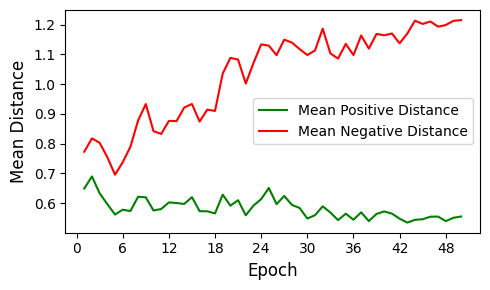

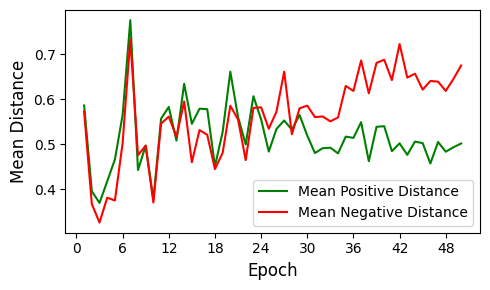

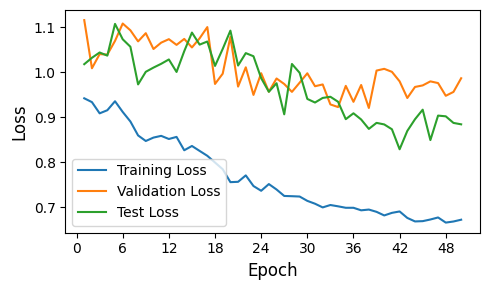

In [82]:
epochs = list(range(1, num_epochs + 1))

# Plot training distances
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(epochs, train_positive_distances, label='Mean Positive Distance', color='g')
ax.plot(epochs, train_negative_distances, label='Mean Negative Distance', color='r')
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('Mean Distance', size=12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
fig.tight_layout()
fig.savefig('./img/step_1/train_distance.svg')
plt.show()

# Plot test distances
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(epochs, test_positive_distances, label='Mean Positive Distance', color='g')
ax.plot(epochs, test_negative_distances, label='Mean Negative Distance', color='r')
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('Mean Distance', size=12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
fig.tight_layout()
fig.savefig('./img/step_1/test_distance.svg')
plt.show()

# Plot losses
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(epochs, train_losses, label='Training Loss')
ax.plot(epochs, val_losses, label='Validation Loss')
ax.plot(epochs, test_losses, label='Test Loss')
ax.set_xlabel('Epoch', size=12)
ax.set_ylabel('Loss', size=12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
fig.tight_layout()
fig.savefig('./img/step_1/loss.svg')
plt.show()


In [83]:
# Save the model state
torch.save(triplet_model.state_dict(), './checkpoints/triplet_model_state_dict.pth')

In [106]:
# Load the model state
triplet_model = ViT().to(device)
triplet_model.load_state_dict(torch.load('./checkpoints/triplet_model_state_dict.pth'))

<All keys matched successfully>